<a href="https://colab.research.google.com/github/nicollysamendonca/GenIAatividade/blob/main/primeiraAtividade.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tarefas para criar um RAG
1. Carregar os dados
2. Criar coluna para representar cada review
3. Criar coluna com embeddings
4. Criar função para buscar reviews relevantes a partir de uma query de busca
5. Criar prompt para perguntar ao gpt
6. Enviar prompt para o gpt e mostrar as respostas

## 1. Carregar os dados

In [ ]:
# fonte dos dados: https://github.com/germanojorge/SteamBR

import pandas as pd

df = pd.read_excel("/content/reviews_steam_portugues.xlsx")

## 2. Criar coluna para representar cada review

In [ ]:
df["game"] = df["game"].astype(str)
df["review"] = df["review"].astype(str)
df["texto_para_promtp"] = df["game"] + " recebeu a seguinte review: " + df["review"]

## 3. Criar coluna com embeddings
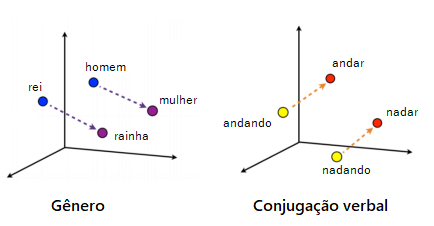

fonte: https://medium.com/turing-talks/word-embedding-fazendo-o-computador-entender-o-significado-das-palavras-92fe22745057

In [ ]:
!pip install python-dotenv

In [ ]:
!pip install openai

  Using cached openai-0.28.1-py3-none-any.whl (76 kB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
llmx 0.0.15a0 requires cohere, which is not installed.
llmx 0.0.15a0 requires tiktoken, which is not installed.


In [ ]:
import os
from dotenv import load_dotenv, find_dotenv

_ = load_dotenv(find_dotenv())

os.environ["OPENAI_API_KEY"]
os.environ['OPENAI_API_BASE']

'https://openai-portodigital.openai.azure.com/'

In [ ]:
import openai

openai.api_type = "azure"
openai.api_key  = os.environ['OPENAI_API_KEY']
openai.api_base = os.environ['OPENAI_API_BASE']
openai.api_version = "2023-05-15"

response = openai.Embedding.create(
    input="OI BRASIL",
    engine="text-similarity-ada-001"
)

In [ ]:
embeddings = response['data'][0]['embedding']
embeddings

## 4. Criar função para buscar reviews relevantes a partir de uma query de busca

In [ ]:
import openai
import time

def text_embedding(text):
    """
    Recebe string, faz chamada ao modelo de embeddings da openai e retorna os embeddings da string
    """
    response = None
    retry_count = 0

    while response is None:
        try:
            response = openai.Embedding.create(engine="text-similarity-ada-001", input=text)
        except Exception as e:
            # Verifique se o erro é devido ao limite de chamadas
            if "call rate limit" in str(e):
                # Espere por um tempo exponencialmente crescente antes de tentar novamente
                time.sleep(2 ** retry_count)
                retry_count += 1
                continue
            else:
                # Se ocorrer outro tipo de erro, lide com ele de acordo com sua lógica de tratamento de erros
                print("Erro ao fazer chamada para a API: ", str(e))
                return None

    return response["data"][0]["embedding"]

In [ ]:
# Cria sample das linhas para fazer menos chamadas ao modelo
df_menor = df.sample(1000)

In [ ]:
df_menor.shape

(1000, 20)

In [ ]:
# criar coluna com os embeddings
df_menor["embeddings"] = df_menor["texto_para_promtp"].apply(lambda linha: text_embedding(linha))

Erro ao fazer chamada para a API:  This model's maximum context length is 2046 tokens, however you requested 2490 tokens (2490 in your prompt; 0 for the completion). Please reduce your prompt; or completion length.
Erro ao fazer chamada para a API:  This model's maximum context length is 2046 tokens, however you requested 2415 tokens (2415 in your prompt; 0 for the completion). Please reduce your prompt; or completion length.
Erro ao fazer chamada para a API:  This model's maximum context length is 2046 tokens, however you requested 2792 tokens (2792 in your prompt; 0 for the completion). Please reduce your prompt; or completion length.
Erro ao fazer chamada para a API:  This model's maximum context length is 2046 tokens, however you requested 2071 tokens (2071 in your prompt; 0 for the completion). Please reduce your prompt; or completion length.
Erro ao fazer chamada para a API:  This model's maximum context length is 2046 tokens, however you requested 2421 tokens (2421 in your promp

In [ ]:
df_menor = df_menor.dropna(subset="embeddings", axis=0)

In [ ]:
from scipy import spatial

def strings_ranked_by_relatedness(
    query: str,
    df: pd.DataFrame,
    relatedness_fn=lambda x, y: 1 - spatial.distance.cosine(x, y),
    top_n: int = 10
) -> tuple[list[str], list[float]]:
    """
    Retorna as linhas do dataframe mais semelhantes a string de busca
    """

    query_embedding = text_embedding(query)

    strings_and_relatednesses = [ ]
    for i, row in df.iterrows():

        #relatedness = relatedness_fn(np.array(query_embedding).flatten(), np.array(row["embedding"]).flatten())
        relatedness = relatedness_fn(query_embedding, row["embeddings"])
        item = (row["texto_para_promtp"], relatedness)
        strings_and_relatednesses.append(item)

    strings_and_relatednesses.sort(key=lambda x: x[1], reverse=True)
    strings, relatednesses = zip(*strings_and_relatednesses)
    return strings[:top_n], relatednesses[:top_n]

In [ ]:
strings, relatednesses = strings_ranked_by_relatedness("Existe algum jogo nas reviews onde o usuário falou de um jogo de corrida com muita ação?",
                              df_menor)
for string, relatedness in zip(strings, relatednesses):
    print(f"{relatedness=:.3f}")
    display(string)

relatedness=0.896


'Racing_TrackManiacanyon recebeu a seguinte review: Um jogo um tanto quanto diferente, se vc está cansado de jogos de corrida comuns talvez esse seja um titulo interessante para se jogar.'

relatedness=0.893


'Indie_QuestofDungeons recebeu a seguinte review: Este é aquele tipo de jogo com uma mecânica simples mas que faz você se divertir por horas.'

relatedness=0.891


'Adventure_TombRumble recebeu a seguinte review: Um jogo bem divertido e bem desafiador para conseguir completar 1 mapa com vários jogadores diversos'

relatedness=0.891


'Adventure_Republique recebeu a seguinte review: Um jogo para refletir.'

relatedness=0.886


'FPS_Screencheat recebeu a seguinte review: Jogo casual e divertido pra jogar com os amigos'

relatedness=0.886


'Action_ThunderTierOne recebeu a seguinte review: Um  jogo que procura simular a movimentação coordenada da equipe visando realizar as missões pré-determinadas sob uma perspectiva bem divertida'

relatedness=0.885


'Simulation_DEEEERSimulator recebeu a seguinte review: Jogo de corno brabissimo'

relatedness=0.885


'Racing_AssetoCorsa recebeu a seguinte review: Bom jogo/simulador!'

relatedness=0.885


'FPS_RAGE recebeu a seguinte review: Um dos melhores jogos pós apocalíptico que já joguei, Tem lá seus defeitos como qualquer outro jogo mas o conteúdo disso aqui é simplesmente deleitoso.'

relatedness=0.884


'Action_Overstep recebeu a seguinte review: Isso sim Que é um jogo de parkour.'

## 5. Criar prompt para perguntar ao gpt
* O modelo possui um limite de tokens, vamos verificar se o limite foi atingido ou não para criar o prompt

In [ ]:
!pip install tiktoken

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 19.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
llmx 0.0.15a0 requires cohere, which is not installed.


In [ ]:
import tiktoken

def num_tokens(text: str) -> int:
    encoding = tiktoken.encoding_for_model("gpt-3.5-turbo-16k")
    return len(encoding.encode(text))

In [ ]:
num_tokens("oi brasil")

3

In [ ]:
num_tokens("Existe algum jogo nas reviews onde o usuário falou de um jogo de corrida com muita ação?")

23

In [ ]:
def montar_query(query: str, df: pd.DataFrame, token_budget: int) -> str:
    linhas, relatednesses = strings_ranked_by_relatedness(query, df)
    introducao = """
    Use o conteúdo abaixo com reviews de jogos para responder a pergunta a seguir.
    O conteúdo das reviews deve ser a sua única fonte para dar as respostas.
    Se você não conseguir encontrar a resposta no conteúdo, escreva "Não consegui encontrar uma resposta."
    """
    pergunta = f"\n\Pergunta: {query}"
    messagem = introducao
    for linha in linhas:
        proxima_linha = f'\n\nSeção com dados das reviews de jogos:\n"""\n{linha}\n"""'
        if num_tokens(messagem + proxima_linha + pergunta) > token_budget:
            break
        else:
            messagem = messagem + proxima_linha

    return messagem + pergunta


In [ ]:
from pprint import pprint

prompt = montar_query(query="Existe algum jogo nas reviews onde o usuário falou de um jogo de corrida com muita ação?",
             df=df_menor,
             token_budget=16000)
pprint(prompt)

('\n'
 '    Use o conteúdo abaixo com reviews de jogos para responder a pergunta a '
 'seguir. \n'
 '    O conteúdo das reviews deve ser a sua única fonte para dar as '
 'respostas. \n'
 '    Se você não conseguir encontrar a resposta no conteúdo, escreva "Não '
 'consegui encontrar uma resposta."\n'
 '    \n'
 '\n'
 'Seção com dados das reviews de jogos:\n'
 '"""\n'
 'Racing_TrackManiacanyon recebeu a seguinte review: Um jogo um tanto quanto '
 'diferente, se vc está cansado de jogos de corrida comuns talvez esse seja um '
 'titulo interessante para se jogar.\n'
 '"""\n'
 '\n'
 'Seção com dados das reviews de jogos:\n'
 '"""\n'
 'Indie_QuestofDungeons recebeu a seguinte review: Este é aquele tipo de jogo '
 'com uma mecânica simples mas que faz você se divertir por horas.\n'
 '"""\n'
 '\n'
 'Seção com dados das reviews de jogos:\n'
 '"""\n'
 'Adventure_TombRumble recebeu a seguinte review: Um jogo bem divertido e bem '
 'desafiador para conseguir completar 1 mapa com vários jogadores 

## 6. Enviar prompt para o gpt e mostrar as respostas

In [ ]:
def perguntar(
    query: str,
    df: pd.DataFrame = df,
    model: str = "gpt-35-turbo-16k",
    print_message: bool = False,
) -> str:
    message = montar_query(query, df, token_budget=16000)
    if print_message:
        print(message)
    messages = [
        {"role": "system", "content": "Você responde perguntas sobre reviews de jogos."},
        {"role": "user", "content": message},
    ]
    response = openai.ChatCompletion.create(
        model=model,
        messages=messages,
        temperature=0,
        engine="gpt-35-turbo-16k"
    )
    response_message = response["choices"][0]["message"]["content"]
    return response_message

In [ ]:
resposta = perguntar("Existe algum jogo nas reviews onde o usuário falou que o jogo era de tiro e divertido?",
    df_menor)
print(resposta)

Sim, o jogo FPS_Screencheat recebeu a seguinte review: "Jogo casual e divertido pra jogar com os amigos".


In [ ]:
montar_query(query="Existe algum jogo nas reviews onde o usuário falou que o jogo era de tiro e divertido?",
             df=df_menor,
             token_budget=16000)

'\n    Use o conteúdo abaixo com reviews de jogos para responder a pergunta a seguir. \n    O conteúdo das reviews deve ser a sua única fonte para dar as respostas. \n    Se você não conseguir encontrar a resposta no conteúdo, escreva "Não consegui encontrar uma resposta."\n    \n\nSeção com dados das reviews de jogos:\n"""\nIndie_QuestofDungeons recebeu a seguinte review: Este é aquele tipo de jogo com uma mecânica simples mas que faz você se divertir por horas.\n"""\n\nSeção com dados das reviews de jogos:\n"""\nFPS_Screencheat recebeu a seguinte review: Jogo casual e divertido pra jogar com os amigos\n"""\n\nSeção com dados das reviews de jogos:\n"""\nAdventure_ThereIsNoGame recebeu a seguinte review: Jogo divertidíssimo!\n\nA ideia de fazer um "jogo sobre ser um jogo" não é original, mas "There is no Game" tem um humor tão perfeito que faz dele um destaque dentro desse gênero.\n\nE como todos jogos desse tipo, quanto menos você souber sobre ele, melhor!\n"""\n\nSeção com dados das 

In [ ]:
resposta = perguntar("Existe algum jogo nas reviews de estratégia de sobrevivência?",
    df_menor)
print(resposta)

Sim, o jogo "SurvivingtheAftermath" recebeu uma review na seção de reviews de jogos de estratégia de sobrevivência.


In [ ]:
resposta = perguntar("Existe algum jogo nas reviews parecido com o jogo prince of persia? prince of persia é um jogo de aventura em terceira pessoa onde o personagem faz saltos, resolve enigmas e luta contra inimigos",
    df_menor)
print(resposta)

Sim, o jogo "Adventure_TheShapeshiftingDetective" é descrito como um jogo estilo "Her Story", que também envolve resolver enigmas e tomar decisões. Embora não seja exatamente igual ao Prince of Persia, possui elementos de aventura e raciocínio semelhantes.


In [ ]:
resposta = perguntar("Existe algum jogo nas reviews parecido com o jogo prince of persia?",
    df_menor)
print(resposta)

Não consegui encontrar uma resposta.


In [ ]:
montar_query(query="Existe algum jogo nas reviews parecido com o jogo prince of persia?",
             df=df_menor,
             token_budget=16000)

'\n    Use o conteúdo abaixo com reviews de jogos para responder a pergunta a seguir. \n    O conteúdo das reviews deve ser a sua única fonte para dar as respostas. \n    Se você não conseguir encontrar a resposta no conteúdo, escreva "Não consegui encontrar uma resposta."\n    \n\nSeção com dados das reviews de jogos:\n"""\nAdventure_Republique recebeu a seguinte review: Um jogo para refletir.\n"""\n\nSeção com dados das reviews de jogos:\n"""\nSimulation_DEEEERSimulator recebeu a seguinte review: Jogo de corno brabissimo\n"""\n\nSeção com dados das reviews de jogos:\n"""\nIndie_QuestofDungeons recebeu a seguinte review: Este é aquele tipo de jogo com uma mecânica simples mas que faz você se divertir por horas.\n"""\n\nSeção com dados das reviews de jogos:\n"""\nIndie_Incandescent recebeu a seguinte review: um jogo simples e divertido para pegar as conquistas\n"""\n\nSeção com dados das reviews de jogos:\n"""\nStrategy_SidMeiersCivilizationIV recebeu a seguinte review: Este não é "um 

In [ ]:
montar_query(query="Existe algum jogo nas reviews parecido com o jogo prince of persia? prince of persia é um jogo de aventura em terceira pessoa onde o personagem faz saltos, resolve enigmas e luta contra inimigos",
             df=df_menor,
             token_budget=16000)

'\n    Use o conteúdo abaixo com reviews de jogos para responder a pergunta a seguir. \n    O conteúdo das reviews deve ser a sua única fonte para dar as respostas. \n    Se você não conseguir encontrar a resposta no conteúdo, escreva "Não consegui encontrar uma resposta."\n    \n\nSeção com dados das reviews de jogos:\n"""\nAdventure_TombRumble recebeu a seguinte review: Um jogo bem divertido e bem desafiador para conseguir completar 1 mapa com vários jogadores diversos\n"""\n\nSeção com dados das reviews de jogos:\n"""\nAdventure_ThereIsNoGame recebeu a seguinte review: Jogo divertidíssimo!\n\nA ideia de fazer um "jogo sobre ser um jogo" não é original, mas "There is no Game" tem um humor tão perfeito que faz dele um destaque dentro desse gênero.\n\nE como todos jogos desse tipo, quanto menos você souber sobre ele, melhor!\n"""\n\nSeção com dados das reviews de jogos:\n"""\nIndie_QuestofDungeons recebeu a seguinte review: Este é aquele tipo de jogo com uma mecânica simples mas que fa